<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Predicting shots made per game by Kobe Bryant

_Authors: Kiefer Katovich (SF)_

---

In this lab you'll be using regularized regression penalties Ridge, Lasso, and Elastic Net to try and predict how many shots Kobe Bryant made per game in his career.

The Kobe shots dataset has hundreds of columns representing different characteristics of each basketball game. Fitting an ordinary linear regression using every predictor would dramatically overfit the model considering the limited number of observations (games) we have available. Furthermore, many of the predictors have significant multicollinearity. 


**Warning:** Some of these calculations are computationally expensive and may take a while to execute.  It may be worth while to only use a portion of the data to perform these calculations, especially if you have experienced kernel issues in the past.

---

### 1. Load packages and data

In [1]:
import numpy as np
import pandas as pd
import patsy

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.regressor import PredictionError, ResidualsPlot
from scipy import stats
import statsmodels.stats.api as sms
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
kobe = pd.read_csv('../03_02-lab-cross_validation_regularization-regression/datasets/kobe_superwide_games.csv')

---

### 2. Examine the data

- How many columns are there?
- Examine what the observations (rows) and columns represent.
- Why is this data that regularization might be particularly useful for?

### Answers

2.1: There are 645 columns

2.2: Each row represents a game played by Kobe Bryant. The columns show the season in which a game took place against a certain team. There are also columns specifying what kind of shot exactly was made.

2.3: Regularization could be particularly helpful for modeling this data because there are so many features that can be input. Our linear regression model will learn a coefficient for every feature we include in the model, regardless of whether that feature has the signal or the noise. This is especially a problem when p (number of features) is close to n (number of observations), because that model will naturally have high variance.

In [3]:
# Check the shape of our dataframe
kobe.shape

(1558, 645)

In [4]:
# Print the first 5 rows
kobe.head()

,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
3,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
4,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5


In [5]:
# Check the columns.. that's a lot of columns
kobe.columns

Index(['SHOTS_MADE', 'AWAY_GAME', 'SEASON_OPPONENT:atl:1996-97',
       'SEASON_OPPONENT:atl:1997-98', 'SEASON_OPPONENT:atl:1999-00',
       'SEASON_OPPONENT:atl:2000-01', 'SEASON_OPPONENT:atl:2001-02',
       'SEASON_OPPONENT:atl:2002-03', 'SEASON_OPPONENT:atl:2003-04',
       'SEASON_OPPONENT:atl:2004-05',
       ...
       'ACTION_TYPE:tip_layup_shot', 'ACTION_TYPE:tip_shot',
       'ACTION_TYPE:turnaround_bank_shot',
       'ACTION_TYPE:turnaround_fadeaway_bank_jump_shot',
       'ACTION_TYPE:turnaround_fadeaway_shot',
       'ACTION_TYPE:turnaround_finger_roll_shot',
       'ACTION_TYPE:turnaround_hook_shot', 'ACTION_TYPE:turnaround_jump_shot',
       'SEASON_GAME_NUMBER', 'CAREER_GAME_NUMBER'],
      dtype='object', length=645)

In [6]:
# Check for missing values
kobe.isna().sum().sum()

0

In [7]:
#Check for duplicates
kobe.duplicated().sum()

0

---

### 3. Make predictor and target variables. Standardize the predictors.

Why is normalization necessary for regularized regressions?

Answer:<br>
Standardization is necessary for regularized regression because the beta values for each predictor variable must be on the same scale. If betas are different sizes just because of the scale of predictor variables then the regularization term can't determine which betas are more/less important based on their size. Our penalty term for regularization depends on these coefficients. Scaling is required so that the regularization penalizes each variable equally.

* Perform `train-test-split` on your data to create two data sets - a training data set and a validation(test) data set
* Use the `sklearn.preprocessing` class `StandardScaler` to standardize the predictors.

In [8]:
# Create a dataframe of numeric columns only
numerical_cols = kobe._get_numeric_data()
numerical_cols

,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1,1
1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,2,2
2,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,3,3
3,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,4,4
4,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,4.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.105263,0.0,0.000000,0.052632,62,1555
1554,4.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,63,1556
1555,9.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.045455,0.0,0.045455,0.045455,64,1557
1556,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.000000,65,1558


In [9]:
# Create our features matrix
X = kobe.iloc[:, 1:]
# Create our target series
y = kobe['SHOTS_MADE']

In [10]:
# Check the shapes of our features and target
print(X.shape)
print(y.shape)

(1558, 644)
(1558,)


In [11]:
# Perform train-test-split with 90/10 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [12]:
# Initialize the StandardScaler object
ss = StandardScaler()

# Scale your X features
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

---

### 4. Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

* Instantiate your linear regresesion model
* Train your model with training data set
* Evaluate your model's performance:
    * Interprete model's cross-validation score
        * Cross-validate the $R^2$ of an ordinary linear regression model with 10 cross-validation folds.
    * Compare the model's train score and test score
    * Comment if the model is overfitting and/or underfitting?

In [13]:
#Instantiate your model
linreg = LinearRegression()
# Obtain Cross-validation scores
print(cross_val_score(linreg, Xs_train, y_train, cv=10), '\n')
# Obtain MEAN Cross-validation score
print(cross_val_score(linreg, Xs_train, y_train, cv=10).mean())

[-8.45477731e+27 -1.33773265e+27 -8.13222334e+27 -6.29516405e+26
 -1.27082701e+27 -1.12328377e+27 -9.88200715e+26 -2.16697615e+27
 -3.86723772e+27 -2.63189857e+27] 

-3.0602673647633203e+27


In [14]:
# Train your model
linreg.fit(Xs_train, y_train)

LinearRegression()

In [15]:
# Train score:
print(linreg.score(Xs_train, y_train))

0.809987987670975


In [16]:
# Test score:
print(linreg.score(Xs_test, y_test))

-2.215637396127049e+26


**Comment here**

What metric is being used here?
> Answer: The R2 or coefficient of determination. This value represents the the proportion of the variation in the target variable that is predictable from the features variable(s). We can use this value as a measure of how well a statistical model can predict an outcome.

How is the model performance? Interpret the metric score:
> Answer: The model is severely overfit. The R2 for the test set is negative and this means that our model performs much worse on predictions than a null model using just the mean. The huge difference in R2 between the train and the test scores is a sign of overfit. Another indicator of overfitting is when the training score is higher than the validation score. The model performs better on data it trained on compared to 'unseen' data. Data used during validation is unseen by the model.


---

### 5. Find an optimal value for Ridge regression alpha using `RidgeCV`.

[Go to the documentation and read how RidgeCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

> *Hint: once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Ridge performs best searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit!


In [17]:
# Set up a list of ridge alphas to check.
# np.logspace generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.
r_alphas = np.logspace(0, 5, 100)

# Cross-validate over our list of ridge alphas and fit our model
ridge_cv = RidgeCV(alphas=r_alphas,scoring='r2',cv=5).fit(Xs_train, y_train)

In [18]:
# Finding our best alpha for ridge
ridge_cv.alpha_

1353.0477745798062

---

### 6. Evaluate `RidgeCV` model's performance.

#### 6a. Cross-validate the Ridge regression $R^2$ with the optimal alpha.

Is it better than the Linear regression? If so, why might this be?

In [19]:
# Create our ridge model using our best alpha as determined from RidgeCV
ridge = Ridge(alpha=ridge_cv.alpha_)

# Obtain Cross-validation scores
print(cross_val_score(ridge, Xs_train, y_train, cv=10), '\n')
# Obtain MEAN Cross-validation score
print(cross_val_score(ridge, Xs_train, y_train, cv=10).mean())

[0.55689802 0.6307883  0.68781202 0.61816486 0.64925295 0.60174734
 0.57084807 0.67667329 0.52873249 0.65283006] 

0.6173747410906861


**Comment here**

Our model performs much better than our 'vanilla' Linear Regression model. There is likely so much multicollinearity in the data that the "vanilla" regression overfits and has bogus coefficients on predictors. Ridge is able to manage the multicollinearity and get a good out-of-sample result.

The reason why this works is that highly correlated data will produce coefficient estimates that have extremely large variance, rendering the estimates unreliable. When comparing LASSO (since later we will use LASSO), Ridge is a better choice if we are interested in various effects (of the features) and don’t want them to be dropped from the model. Ridge, unlike LASSO which eliminates coefficients, makes the coefficients less correlated.


#### 6b. Comment how the model is performing by interpretating its train score and test score.

In [20]:
# Fit our ridge model on our train data
ridge.fit(Xs_train, y_train)

Ridge(alpha=1353.0477745798062)

In [21]:
# Train score:
ridge_train_score = ridge.score(Xs_train, y_train)
ridge_train_score

0.7643762472389026

In [22]:
# Test score:
ridge_test_score = ridge.score(Xs_test, y_test)
ridge_test_score

0.6173485051990322

**Comment here**

How is the model performance? Interpret the metric score:
> * The model has much less overfit than the baseline non-regularized linear regression model.
> * The model has better performance on the test data set, obtaining a test score of 0.617 which is closer to the train score of 0.764, when compared to the baseline model. However, it is still overfitting as the difference between test and train scores is large. We can see further evidence of overfitting from the difference between our cross validated score of 0.617 and the train score.

---
### 7. Find an optimal value for Lasso regression alpha using LassoCV

Find an optimal value for Lasso regression alpha using `LassoCV`.

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) It is very similar to `RidgeCV`.

> *Hint: again, once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Lasso, unlike Ridge, performs best searching for alpha through linear space (`np.linspace`). However, you can actually let the LassoCV decide itself what alphas to use by instead setting the keyword argument `n_alphas=` to however many alphas you want it to search over. It is recommended to let sklearn choose the range of alphas.

_**Tip:** If you find your CV taking a long time and you're not sure if its working set `verbose =1`._

In [23]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over 200 alphas and fit our model
lasso_cv = LassoCV(n_alphas= 200, cv=5, max_iter=50000).fit(Xs_train, y_train)

In [24]:
# Finding our best alpha for lasso
lasso_cv.alpha_

0.09060367455843969

---
### 8. Evaluate `LassoCV` model's performance.
#### 8a. Cross-validate the Lasso regression $R^2$ with the optimal alpha.

Is it better than the Linear regression? Is it better than Ridge? What do the differences in results imply about the issues with the dataset?

In [25]:
# Create our ridge model using our best alpha as determined from LassoCV
lasso = Lasso(alpha=lasso_cv.alpha_)

# Obtain Cross-validation scores
print(cross_val_score(lasso, Xs_train, y_train, cv=10), '\n')
# Obtain MEAN Cross-validation score
print(cross_val_score(lasso, Xs_train, y_train, cv=10).mean())


[0.60106088 0.67419338 0.68869503 0.64852124 0.67160309 0.61310696
 0.56101928 0.69462345 0.56542999 0.67027378] 

0.6388527090653126


**Comment here**

LASSO 'zeroes' out coefficients, although how this is chosen is arbitrary and can change our model. In this regard, LASSO favours a 'sparse' model with fewer coefficients and is useful if we want to 'zero' out irrelevant features. Comparing the scores from Ridge and LASSO regularized models, my intuition is that LASSO regularisation is better because our dataset has too many features which may be irrelevant for modelling. Although one could make a case for better feature engineering and choosing more relevant features, sometimes in the interest of time and lack of domain knowledge, it might be excusable to let the machine do the heavy lifting for us (my opinion).

As for a comparison between the LASSO regularized model and the vanilla linear regression, it should suffice to say that the LASSO model is much better than the overfit vanilla linear regression model.

#### 8b. Comment how the model is performing by interpretating its train score and test score.

In [26]:
# Fit our lasso model on our train data
lasso.fit(Xs_train, y_train)

Lasso(alpha=0.09060367455843969)

In [27]:
# Train score:
lasso_train_score = lasso.score(Xs_train, y_train)
lasso_train_score

0.68924941695382

In [28]:
# Test score:
lasso_test_score = lasso.score(Xs_test, y_test)
lasso_test_score

0.6574498753352525

**Comment here**

How is the model performance? Interpret the metric score:

- For our lasso regularized model, we have a test score of 0.657, a train score of 0.689 and a cross validated score of 0.638. When compared to the ridge regularized model, there is an improvement on model performance on the test and cross-validated scores, and a deprovement on train score. From these results I will conclude that this model has more bias (less complexity) than our ridge model. This is reflected in the greater error on the training set. A model with more bias, will have correspondingly less variance than a more complicated model and we can see this reflected in the better test scores for our lasso model.

---

### 9. Look at the coefficients for variables in the Lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original dataset are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots Kobe made in a game?

> **Note:** if you only fit the Lasso within `cross_val_score`, you will have to refit it outside of that
function to pull out the coefficients.

In [29]:
# Check the list of columns in our dataframe
kobe.columns

Index(['SHOTS_MADE', 'AWAY_GAME', 'SEASON_OPPONENT:atl:1996-97',
       'SEASON_OPPONENT:atl:1997-98', 'SEASON_OPPONENT:atl:1999-00',
       'SEASON_OPPONENT:atl:2000-01', 'SEASON_OPPONENT:atl:2001-02',
       'SEASON_OPPONENT:atl:2002-03', 'SEASON_OPPONENT:atl:2003-04',
       'SEASON_OPPONENT:atl:2004-05',
       ...
       'ACTION_TYPE:tip_layup_shot', 'ACTION_TYPE:tip_shot',
       'ACTION_TYPE:turnaround_bank_shot',
       'ACTION_TYPE:turnaround_fadeaway_bank_jump_shot',
       'ACTION_TYPE:turnaround_fadeaway_shot',
       'ACTION_TYPE:turnaround_finger_roll_shot',
       'ACTION_TYPE:turnaround_hook_shot', 'ACTION_TYPE:turnaround_jump_shot',
       'SEASON_GAME_NUMBER', 'CAREER_GAME_NUMBER'],
      dtype='object', length=645)

In [30]:
# Create a list of this columns
col_list = list(kobe.columns)
# Remove the target column
col_list.remove('SHOTS_MADE')
# Create a list of our lasso coefficients
coef_list = list(lasso.coef_)
# Iterate through our coefficients and columns name list and assign them as key: value pair to a dictionary
lasso_dict = dict(zip(col_list, coef_list))

# Sort our dictionary by values
sorted_lasso_dict = sorted(lasso_dict.items(), key=lambda x:x[1])
# Print out the first 10 rows of this dictionary
sorted_lasso_dict[:10]

[('ACTION_TYPE:jump_shot', -0.23664278543406095),
 ('ACTION_TYPE:layup_shot', -0.10845234484905487),
 ('SEASON:2015-16', -0.08903348744030838),
 ('ACTION_TYPE:driving_floating_jump_shot', -0.08727721848674054),
 ('SEASON_OPPONENT:bos:2015-16', -0.07361963272720545),
 ('SEASON_OPPONENT:bos:2002-03', -0.05434485334303723),
 ('SEASON_OPPONENT:njn:2002-03', -0.04489241323197893),
 ('SEASON_OPPONENT:gsw:2015-16', -0.03443381376980793),
 ('SEASON:2014-15', -0.03442534895951263),
 ('SEASON_OPPONENT:sas:2014-15', -0.03180909009358258)]

In [31]:
# Gives the total number of lasso coefficients 
length_of_lasso_coef = len(lasso.coef_)
# Gives the number of coefficients that are more than zero
lasso_more_than_zero = len(lasso.coef_[lasso.coef_ > 0])
# Finding % of lasso coefficients that were zeroed out by lasso
print(f'The percentage of coefficients zeroed out by lasso is {(1 - lasso_more_than_zero/length_of_lasso_coef) * 100}%')

The percentage of coefficients zeroed out by lasso is 92.54658385093167%


In [32]:
# Print out the 10 most important predictors based on magnitude
sorted_lasso_dict[:10]

[('ACTION_TYPE:jump_shot', -0.23664278543406095),
 ('ACTION_TYPE:layup_shot', -0.10845234484905487),
 ('SEASON:2015-16', -0.08903348744030838),
 ('ACTION_TYPE:driving_floating_jump_shot', -0.08727721848674054),
 ('SEASON_OPPONENT:bos:2015-16', -0.07361963272720545),
 ('SEASON_OPPONENT:bos:2002-03', -0.05434485334303723),
 ('SEASON_OPPONENT:njn:2002-03', -0.04489241323197893),
 ('SEASON_OPPONENT:gsw:2015-16', -0.03443381376980793),
 ('SEASON:2014-15', -0.03442534895951263),
 ('SEASON_OPPONENT:sas:2014-15', -0.03180909009358258)]

---

### 10. Find an optimal value for Elastic Net regression alpha using `ElasticNetCV`.

[Go to the documentation and read how ElasticNetCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: strength of regularization
- `l1_ratio`: amount of ridge vs. lasso (0 = all ridge, 1 = all lasso)
    
Do not include 0 in the search for `l1_ratio`: it will not allow it and break!

You can use `n_alphas` for the alpha parameters instead of setting your own values: highly recommended!

Also - be careful setting too many l1_ratios over cross-validation folds in your search. It can take a very long time if you choose too many combinations and for the most part there are diminishing returns in this data.

In [33]:
# Set up a list of l1 ratios.
enet_ratio = [.1, .5, .7, .9, .95, .99, 1]
# Instantiate model.
enet_model = ElasticNetCV(n_alphas=100, l1_ratio=enet_ratio, cv=10).fit(X_train, y_train)

In [34]:
# Print out the best alpha
print(enet_model.alpha_)
# Print out the best l1_ratio
print(enet_model.l1_ratio_)

0.5643454592074496
1.0


---

### 11. Cross-validate the ElasticNet $R^2$ with the optimal alpha and l1_ratio.

How does it compare to the Ridge and Lasso regularized regressions?

In [35]:
# Create our elastic net model with the best alpha and l1_ratio
enet = ElasticNet(alpha=enet_model.alpha_, l1_ratio=enet_model.l1_ratio_)
# Obtain Cross-validation scores
print(cross_val_score(enet, Xs_train, y_train, cv=10), '\n')
# Obtain MEAN Cross-validation score
print(cross_val_score(enet, Xs_train, y_train, cv=10).mean())

[0.53339288 0.58077172 0.63410037 0.59159569 0.6038666  0.55357761
 0.48899556 0.63088323 0.5057938  0.57924532] 

0.5702222789210893


In [36]:
# Fit our elasticnet model on our train data
enet.fit(Xs_train, y_train)

ElasticNet(alpha=0.5643454592074496, l1_ratio=1.0)

In [37]:
# Train score:
enet_train_score = enet.score(Xs_train, y_train)
enet_train_score

0.5837819495406973

In [38]:
# Test score:
enet_test_score = enet.score(Xs_test, y_test)
enet_test_score

0.5881728219445518

#### Model Comparison to LASSO and Ridge
For the elasticnet model, we get a test score of 0.588, a train score of 0.583 and a cross validation score of 0.570. These scores are very close to each other and would seem to imply that our model has not overfit to the training data. BUT our model definitely has underfit, in that our model has not been able to properly capture the underlying relationship between the input and output variables.

Our original lasso model has outperformed both the ridge model and the elasticnet model. In fact if we look at the l1_ratio chosen by our elasticnet model, the value of '1' means our model is only using LASSO regularization, but with a different alpha penalty as compared to our stand-alone lasso model. The different alpha penalty used would account for the difference in model performance

---

### 12. [Bonus] Compare the residuals for the Ridge and Lasso visually.


In [39]:
# Create the predictions using ridge model
ridge_pred = ridge.predict(Xs_test)
# Find our ridge residuals
ridge_resids = y_test - ridge_pred

In [40]:
# Create the predictions using lasso model
lasso_pred = lasso.predict(Xs_test)
# Find our lasso residuals
lasso_resids = y_test - lasso_pred

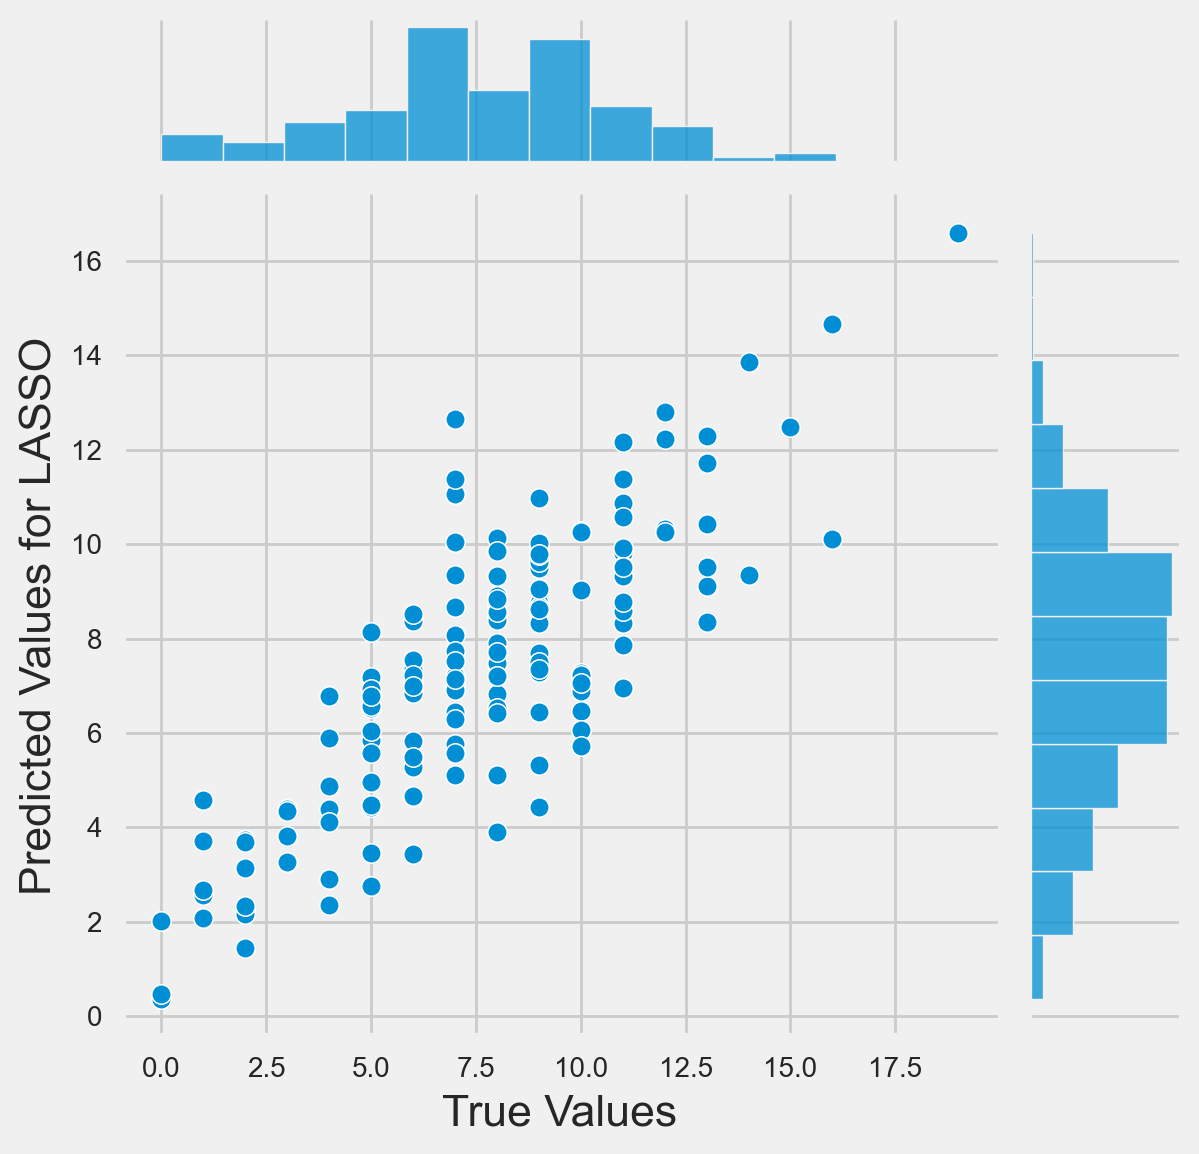

In [41]:
# Joint plot for lasso predictions against true y-values(test)
sns.jointplot(y=lasso_pred, x=y_test)
plt.ylabel('Predicted Values for LASSO', fontsize = 16)
plt.xlabel('True Values', fontsize = 16);

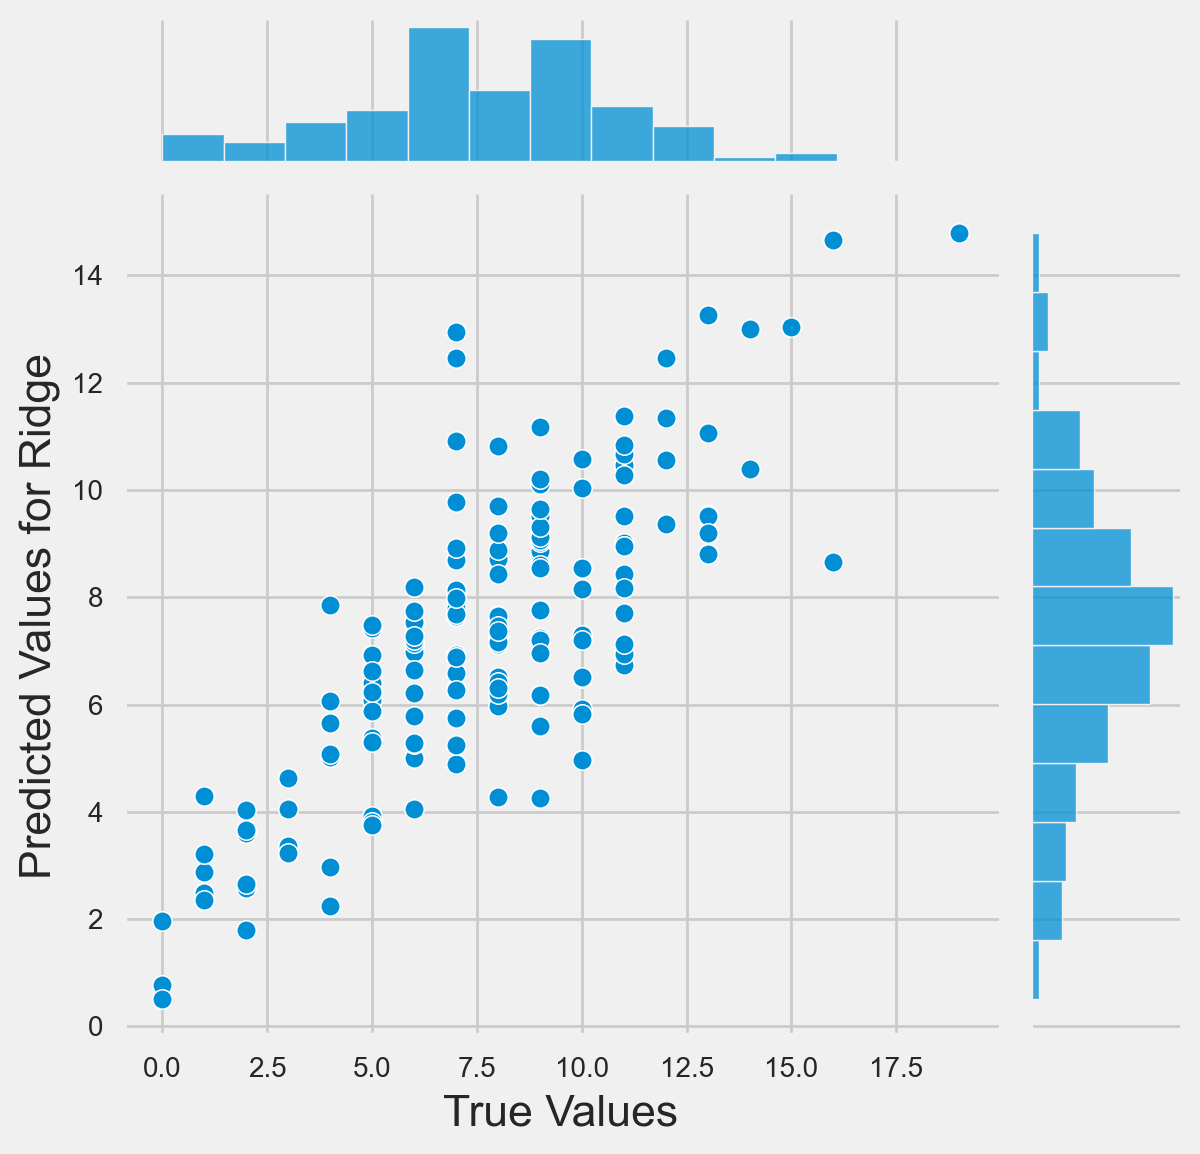

In [42]:
# Joint plot for ridge predictions against true y-values(test)
sns.jointplot(y=ridge_pred, x=y_test)
plt.ylabel('Predicted Values for Ridge', fontsize = 16)
plt.xlabel('True Values', fontsize = 16);

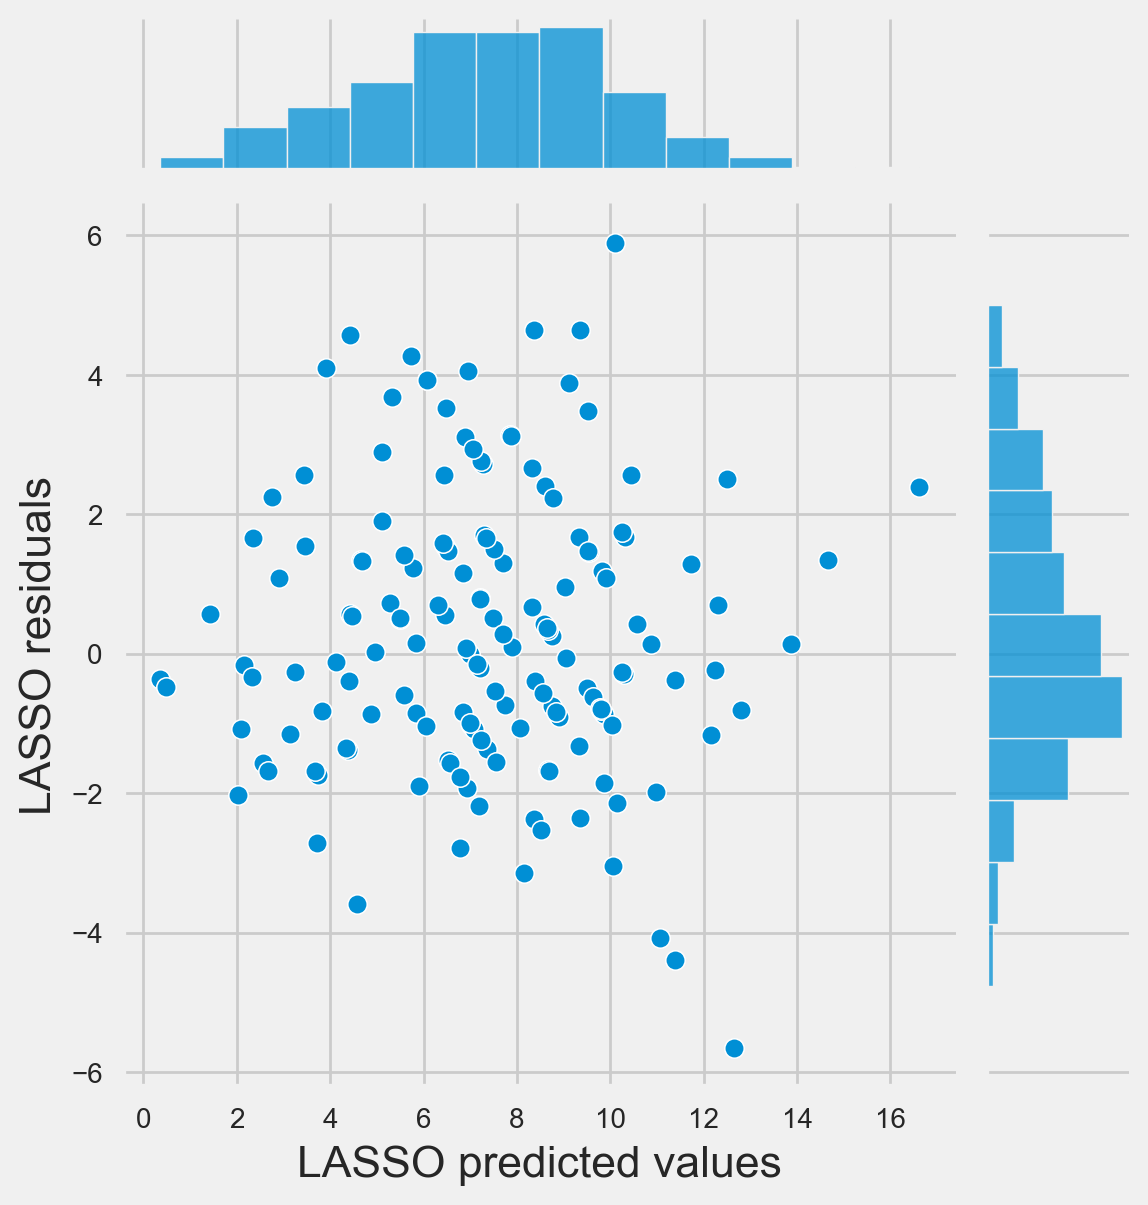

In [43]:
# Joint plot for lasso predictions against lasso residuals
sns.jointplot(x=lasso_pred, y=lasso_resids)
plt.ylabel('LASSO residuals', fontsize = 16)
plt.xlabel('LASSO predicted values', fontsize = 16);

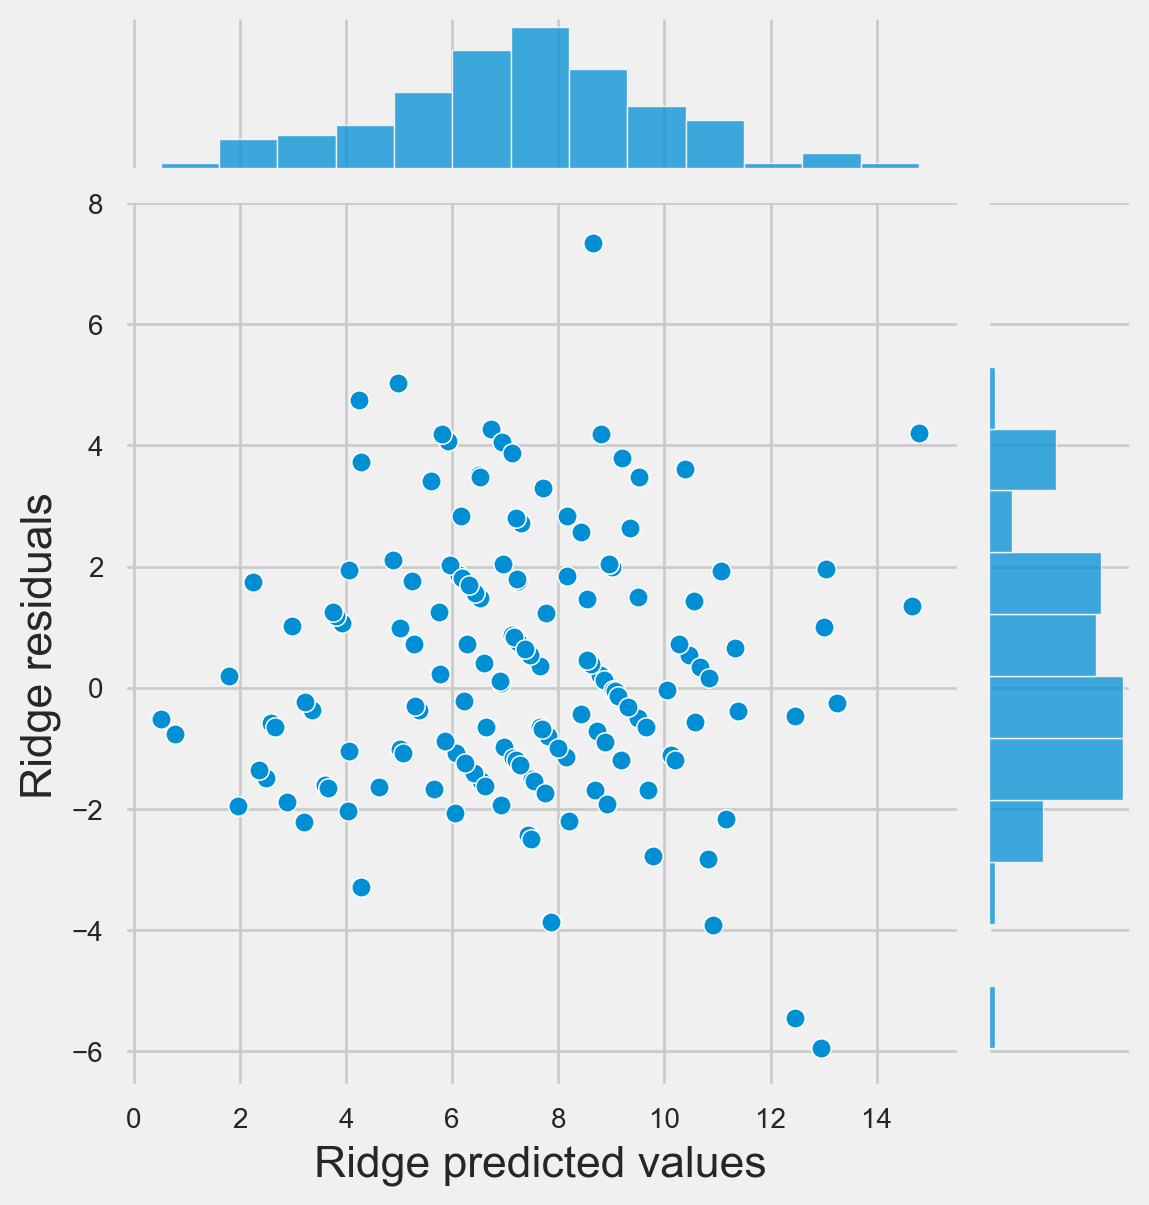

In [44]:
# Joint plot for ridge predictions against ridge residuals
sns.jointplot(x=ridge_pred, y=ridge_resids)
plt.ylabel('Ridge residuals', fontsize = 16)
plt.xlabel('Ridge predicted values', fontsize = 16);

#### Note

For the above plots, I have recreated them using yellowbrick and added my interpretation of the visualisations in that section.

#### Probability Plot (below)

For probability plots, if the samples plotted against the quantiles line up, then the residuals are normal. We can
see that this fails in both cases for LASSO residuals and ridge residuals.

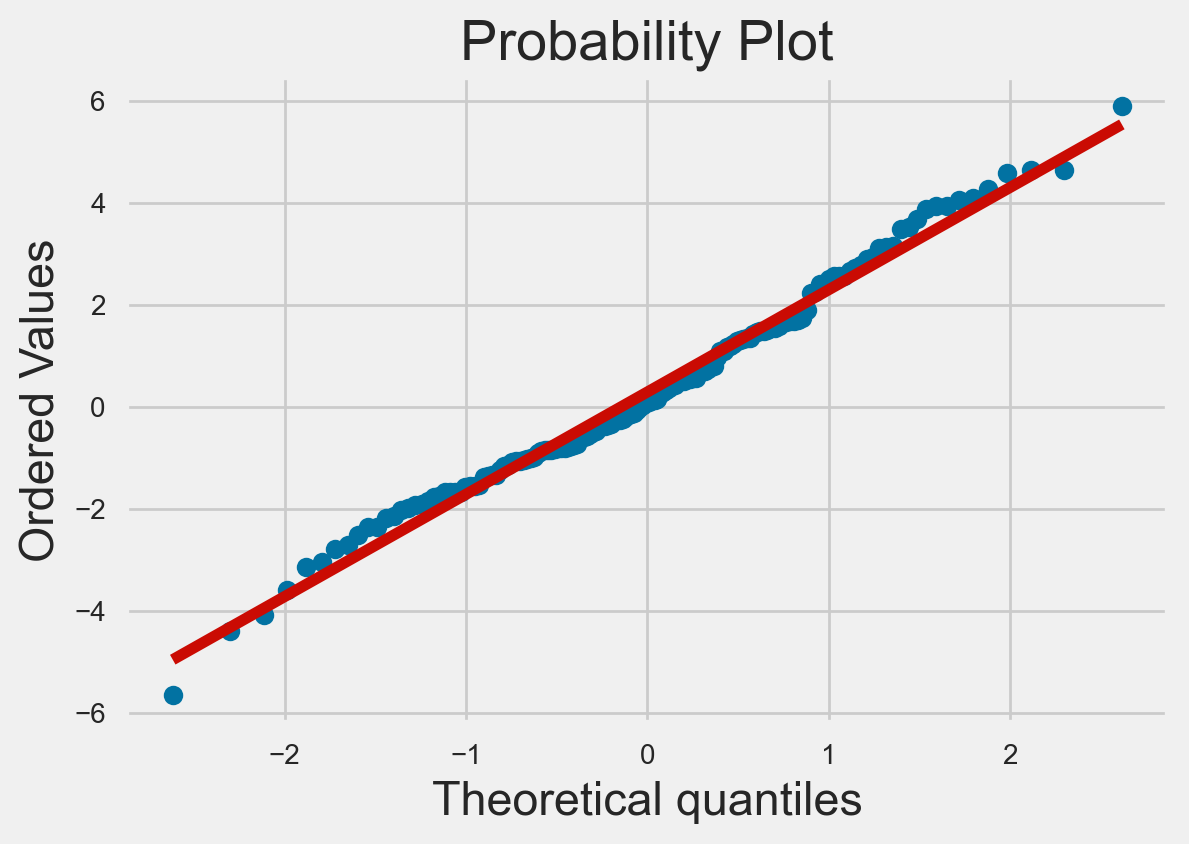

In [45]:
# We can also create a probability plot of lasso residuals
fig, ax = plt.subplots(figsize=(6, 4))
_ = stats.probplot(lasso_resids, plot=ax)

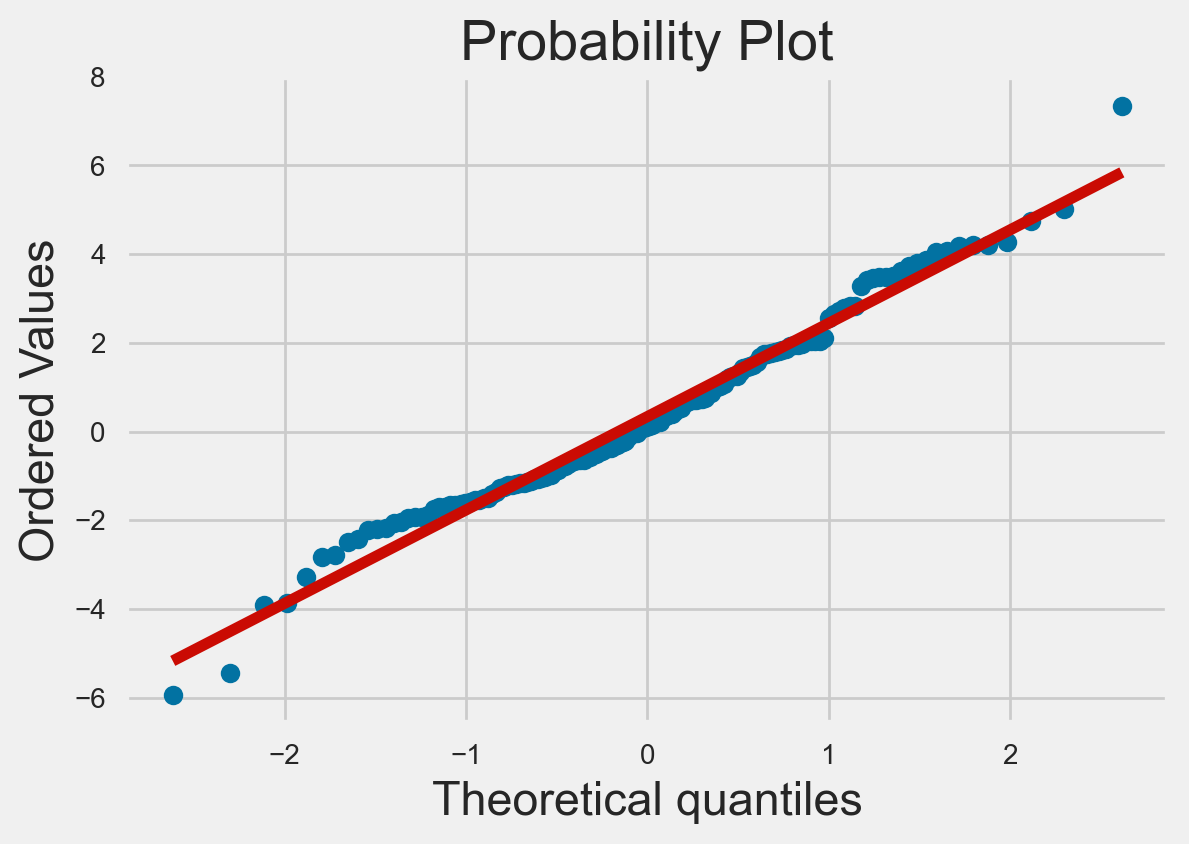

In [46]:
# We can also create a probability plot of ridge residuals
fig, ax = plt.subplots(figsize=(6, 4))
_ = stats.probplot(ridge_resids, plot=ax)

### The below plots were created using the yellowbrick library and are another way to create the seaborn plots I have created above

#### Prediction Error Plot (below)
A prediction error plot shows the real targets against the predicted values. For a perfect model these points would line up in
a 45-degree line. As both our LASSO and ridge model seems to predict lower values for the high end of y, the models have some performance issues. 

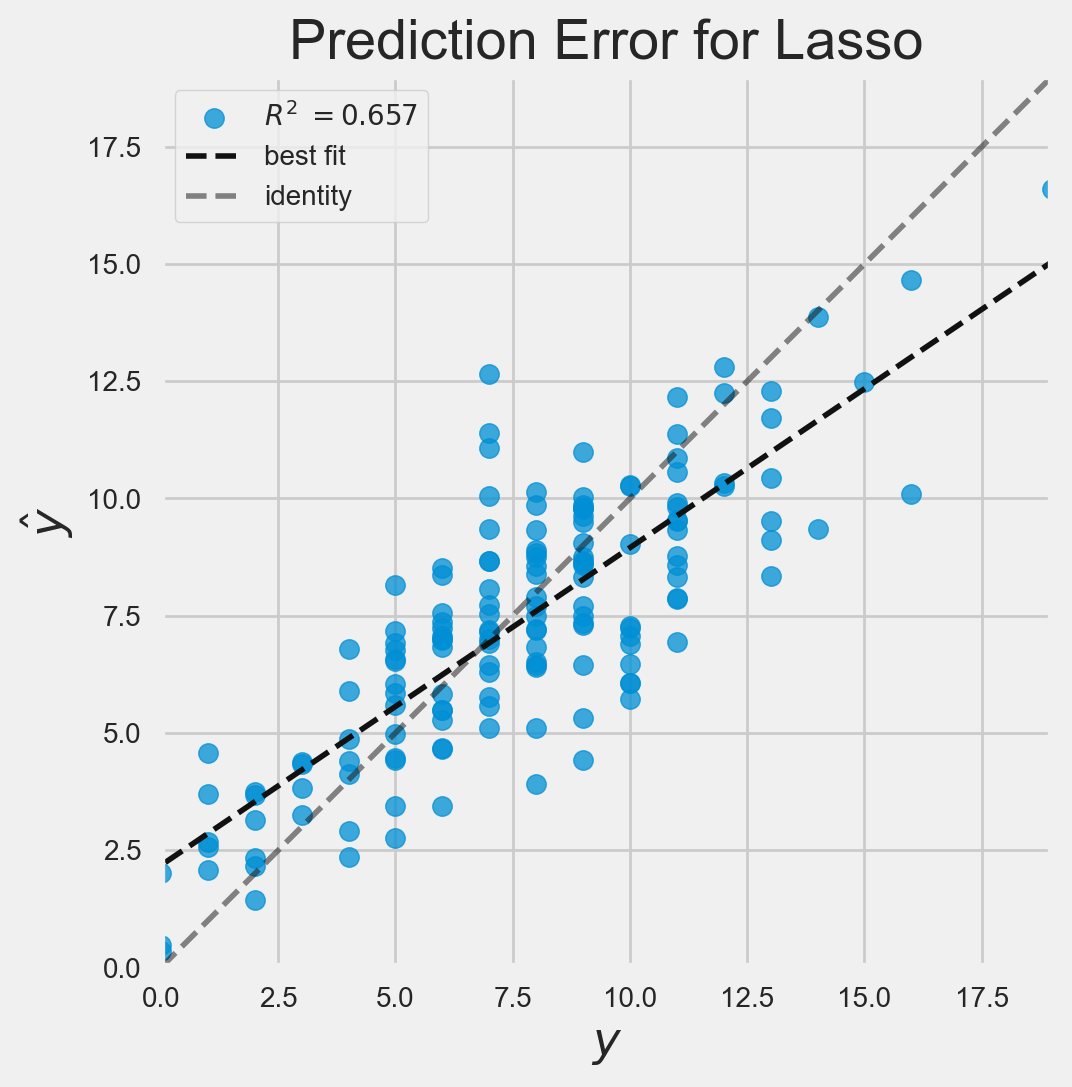

In [47]:
visualizer = PredictionError(lasso)
visualizer.fit(Xs_train, y_train)  
visualizer.score(Xs_test, y_test)  
visualizer.poof();

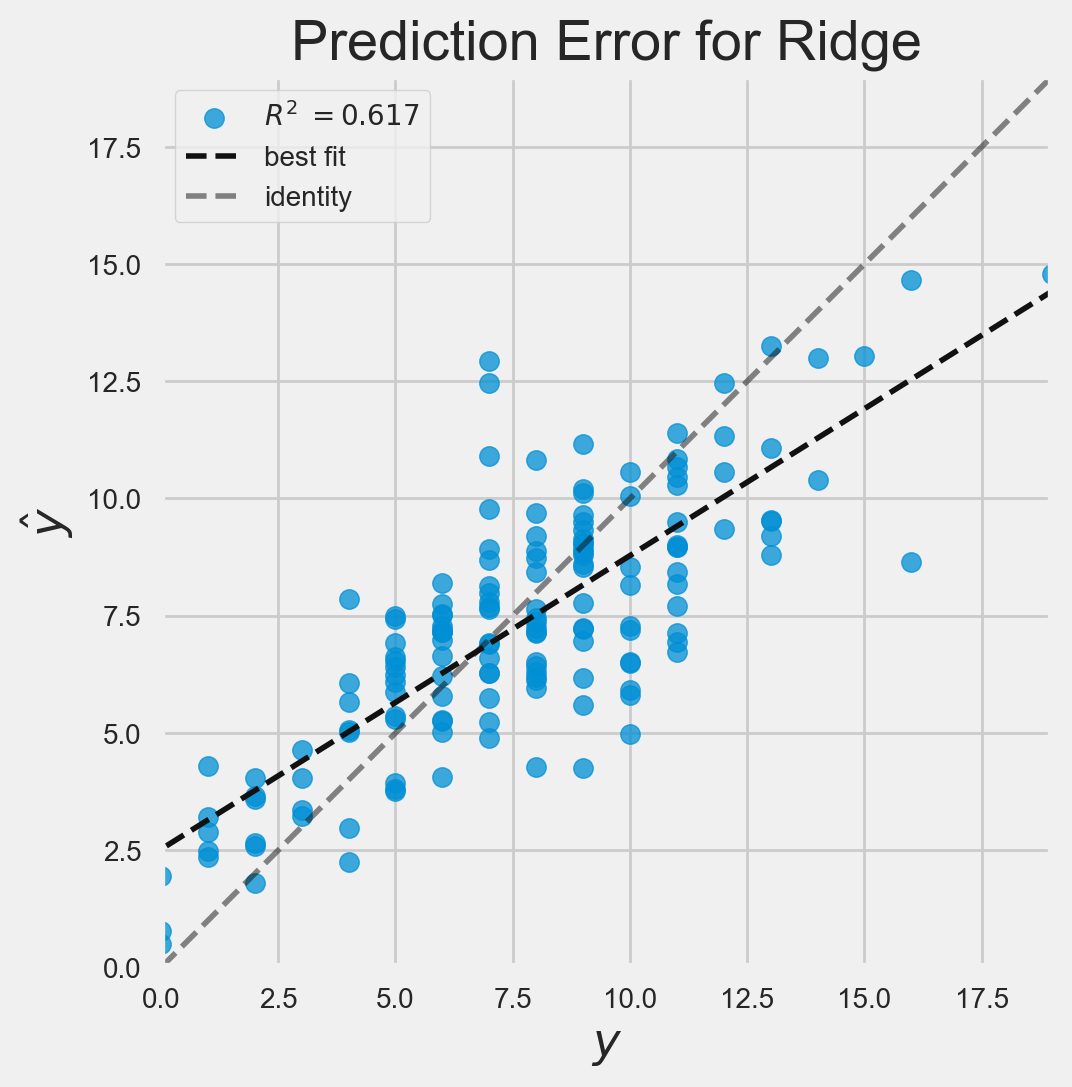

In [48]:
visualizer = PredictionError(ridge)
visualizer.fit(Xs_train, y_train)  
visualizer.score(Xs_test, y_test)  
visualizer.poof();

#### Residuals Plot (below)
Good models (with appropriate R2 scores) will exhibit homoscedasticity. This means the variance is the same for all values of targets regardless of the input. Plotted, this looks like randomly distributed values in a residuals plot. If there are patterns, the model or the data are problematic. Residuals plots also show outliers, which can have a big impact on model fitting. We can see that our residuals for LASSO and ridge appear to have a 'fan' shape, which indicates that the errors exhibit heteroscedasticity.

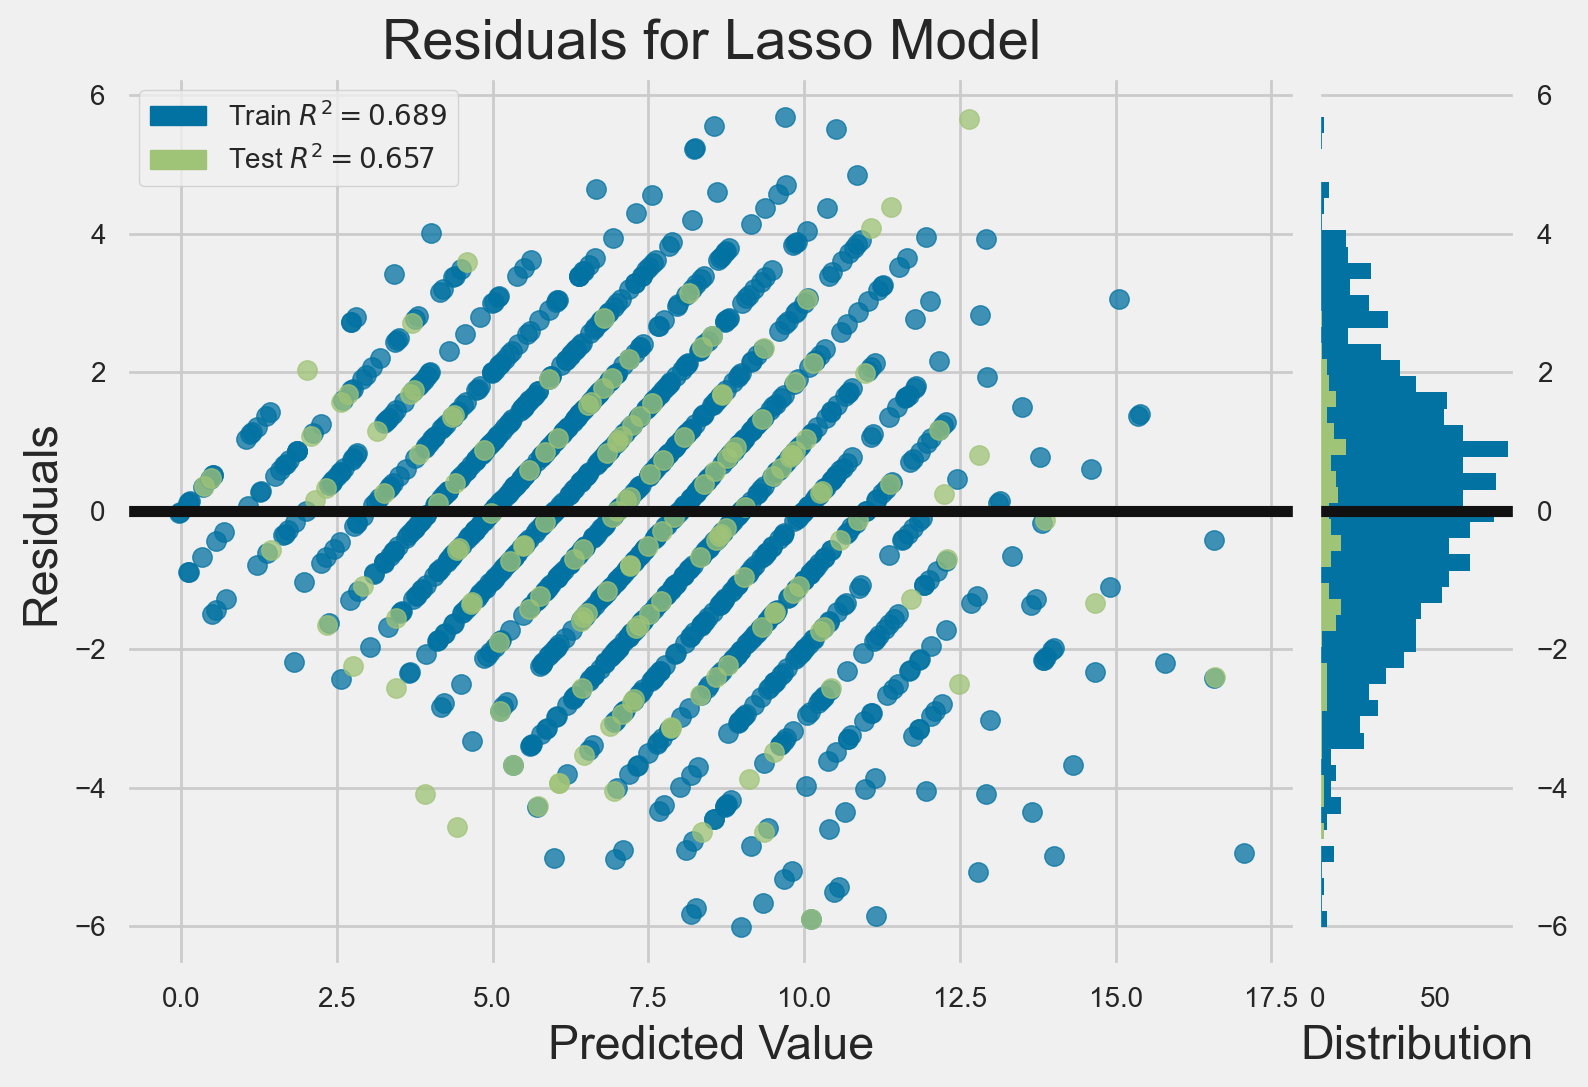

In [49]:
visualizer = ResidualsPlot(lasso)
visualizer.fit(Xs_train, y_train)  
visualizer.score(Xs_test, y_test)  
visualizer.poof();

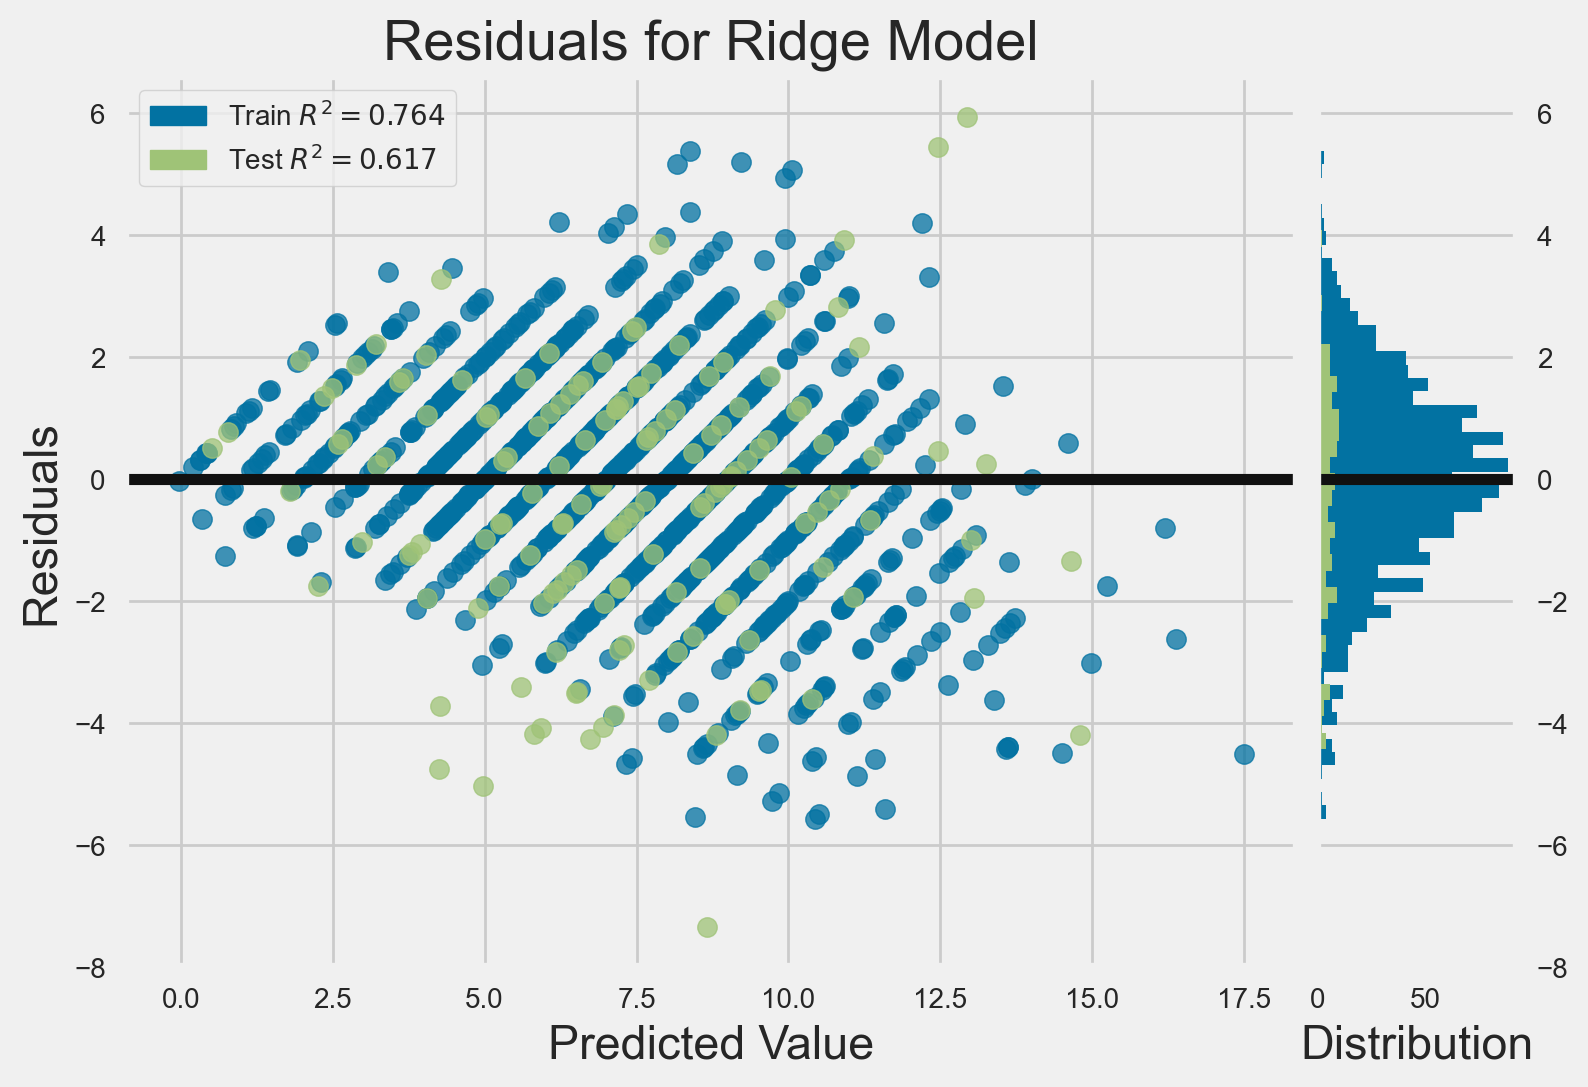

In [50]:
visualizer = ResidualsPlot(ridge)
visualizer.fit(Xs_train, y_train)  
visualizer.score(Xs_test, y_test)  
visualizer.poof();